<h1 style="text-align: center; color:#01872A; font-size: 80px;
background:#daf2e1; border-radius: 20px;
">Animal recognition.</h1>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Contents </span>

## 1. [Introduction.](#Step1)
## 2. [Load data.](#Step2)
## 3. [Define test harness and compile/fit/predict functions.](#Step3)
## 4. [Choose model topology.](#Step4)
## 5. [Reduce overfitting.](#Step5)
## 6. [Conclusion.](#Step6)

<div id="Step1">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1. Introduction. </span>


## Goal: create a NN that can find out what animal is on the photo.

This notebook builds end-to-end animal image classification using Tensorflow.

## 1. Problem.
Identify an animal given its image.

## 2. Data
This data is from Kaggle
https://www.kaggle.com/alessiocorrado99/animals10

## 3. Evaluation
Accuracy, recall, precision, F1.

## 4. Features
There are 10 different animals:
* Butterfly
* Cat
* Chicken
* Cow
* Dog
* Elephant
* Horse
* Sheep
* Spider
* Squirrel

Total number of images: over 26 000.

## Get the workspace ready

In [52]:
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, Dense, Conv2D, MaxPooling2D, \
    Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2, l1, l1_l2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print(tf.__version__)

2.6.0


## Remove error messages of TensorFlow

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"

<div id="Step2">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 2. Load data. </span>

## Create train and test datasets

In [3]:
batch_size = 32
image_height = 80
image_width = 80

In [4]:
train_ds = image_dataset_from_directory('../input/animals10/raw-img/', validation_split=0.2,
                             subset='training', seed=0,
                             image_size=(image_height, image_width),
                             batch_size=batch_size)
test_ds = image_dataset_from_directory('../input/animals10/raw-img/', validation_split=0.2,
                             subset='validation', seed=0,
                             image_size=(image_height, image_width),
                             batch_size=batch_size)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


## Create class names

In [5]:
classes = {num: value for num, value in enumerate(train_ds.class_names)}
n_classes = len(classes)
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", 
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", 
             "mucca": "cow", "pecora": "sheep", "ragno": "spider",
             "scoiattolo": "squirrel"}
classes = {num: translate[value] for num, value in classes.items()}
print(f'Number of classes: {n_classes}')
classes

Number of classes: 10


{0: 'dog',
 1: 'horse',
 2: 'elephant',
 3: 'butterfly',
 4: 'chicken',
 5: 'cat',
 6: 'cow',
 7: 'sheep',
 8: 'spider',
 9: 'squirrel'}

### Check some images

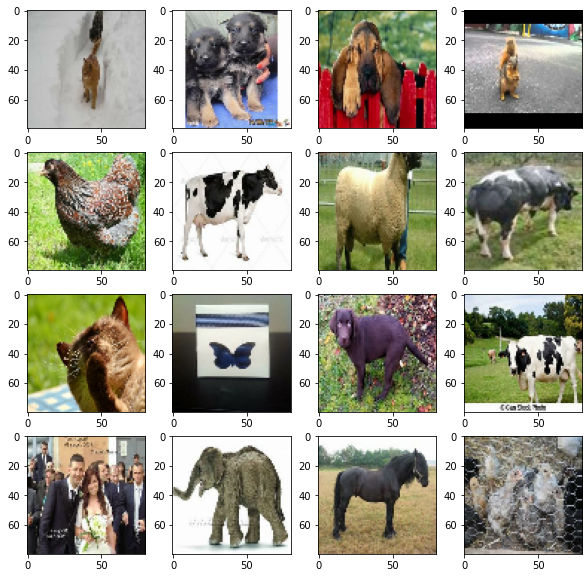

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        # uint - Integers from 0 to 255.
        plt.imshow(images[i].numpy().astype('uint8'))
plt.show()

### Load datasets in memory and allow to prepare next data while current is being processed.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## <span style="color:#01872A; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 30px; "> Step 2 results:</span>

### 1. Train and test datasets are loaded and prepared for usage.

<div id="Step3">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 3. Define test harness and compile/fit/predict functions. </span>


### Callbacks

In [78]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

## Functions to fit models and make predictions

In [10]:
def compile_fit_model(model, callbacks=[], epochs=10):
    model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=test_ds, epochs=epochs,
                        callbacks=callbacks)
    return history

In [11]:
def generate_predictions(model, test_ds):
    predictions = np.array([])
    labels =  np.array([])
    for x, y in test_ds:
        predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
        labels = np.concatenate([labels, y.numpy()])
    return predictions, labels

## Metrics

### Confusion matrix, Classification report, Learning Curve

In [12]:
def results(y_test, y_hat, average=None):
    from sklearn.metrics import confusion_matrix, classification_report, \
        accuracy_score, recall_score, precision_score, f1_score

    unique_y = sorted(y_test.unique())
    if average is None:
        if len(unique_y) == 2:
            average = 'binary'
        else:
            average = 'weighted'
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Overall metrics
    fig.text(0.4, 1.2, f'Accuracy: {accuracy_score(y_test, y_hat):.3f} ',
                 va='top', size=30)
    fig.text(0.3, 1.05,
                f'Recall: {recall_score(y_test, y_hat, average=average):.3f} '
                f'Precision: {precision_score(y_test, y_hat, average=average):.3f} '
                f'F1: {f1_score(y_test, y_hat, average=average):.3f} ', va='bottom',
                size=20)
    value_counts = (y_test == y_hat).value_counts()
    fig.text(0.35, 0.95,f'Total correct: {value_counts[True]} Total incorrect:'
                       f' {value_counts[False]}', fontsize=20)

    # Classification report
    cr = classification_report(y_test, y_hat, output_dict=True)
    sns.heatmap(pd.DataFrame(cr).iloc[:-1, :-3].T, annot=True, ax=axes[0],
                cmap='YlGnBu')
    axes[0].set_xlabel('Metrics', fontsize=20)
    axes[0].set_ylabel('Classes', fontsize=20)
    axes[0].set_title('Classification report', fontsize=20)

    # Confusion matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_hat), columns=unique_y,
                      index=unique_y)
    sns.heatmap(cm, annot=True, ax=axes[1], cmap='YlGnBu', fmt='.0f')
    axes[1].set_xlabel('Predicted', fontsize=20)
    axes[1].set_ylabel('Actual', fontsize=20)
    axes[1].set_title('Confusion matrix', fontsize=20)
    plt.show();

In [13]:
def learning_curve(history):
    metrics = history.model.metrics_names
    n_metrics = len(metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=(16, 5))
    if n_metrics == 1:
        axes = [axes]
    for ax, metric in zip(axes, metrics):
        ax.plot(history.history[metric], label=f'Train {metric}')

        val_metric = 'val_' + metric
        if val_metric in history.history:
            ax.plot(history.history[val_metric], label=f'Test {metric}')
        ax.set_title(metric.capitalize(), size=20)
        ax.legend()


### Model evaluation

In [14]:
def evaluate_results(model, history):
    predictions, labels = generate_predictions(model, test_ds)
    results(pd.Series(labels).map(classes), pd.Series(predictions).map(classes))
    learning_curve(history)

## <span style="color:#01872A; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 30px; "> Step 3 results:</span>

### 1. Functions for fitting model and predicting results are created.
### 2. Test harness defined.

<div id="Step4">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 4. Choose model topology. </span>

### Small model

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 10368)             5088      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                663616    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 669,354
Trainable params: 669,354
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
655/655 [==============================] - 3s 5ms/step - loss: 1.7373 - accuracy: 0.3955 - val_loss: 1.4491 - val_accuracy: 0.5074
Epoch 2/20
655/655 [==============================] - 3s 4ms/step - loss: 1.3437 - accuracy: 0.5467 - val_loss: 1.2814 - val_accuracy: 0.5683
Epoch 3/20
655/655 [==============================] - 3s 5ms/step - loss: 1.1412 - accura

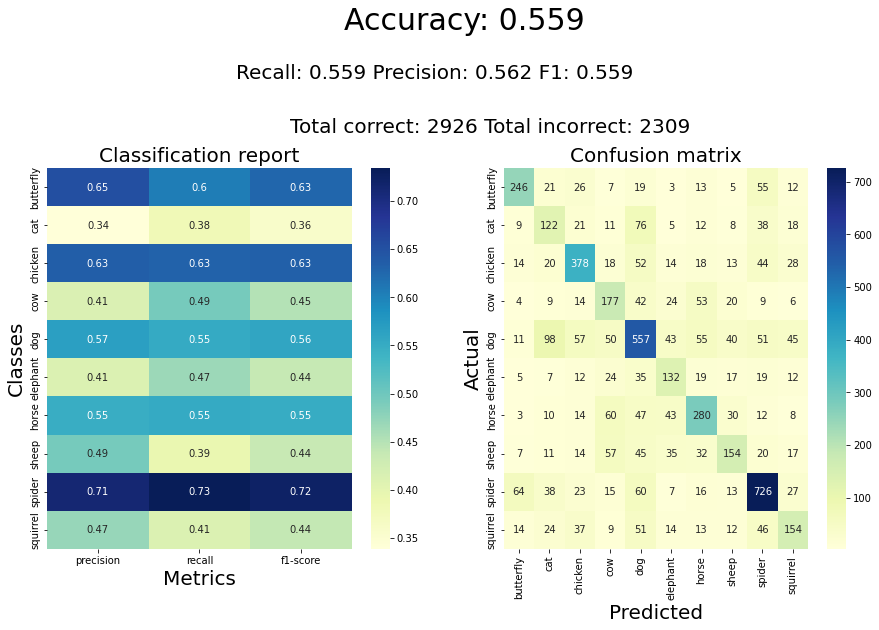

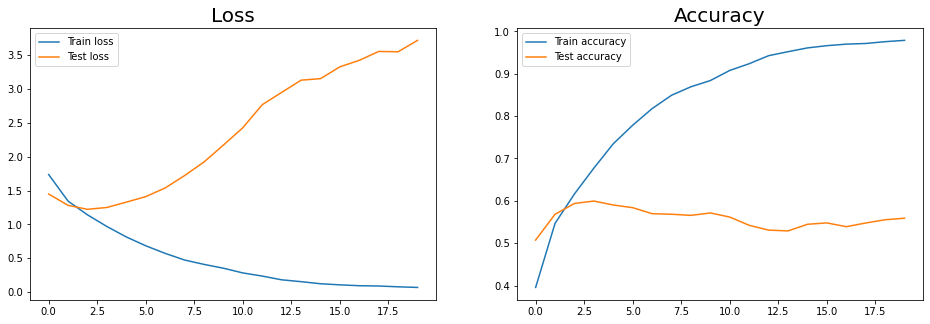

In [20]:
conv_model = tf.keras.Sequential([
    Rescaling(scale=1./255, input_shape=(image_height, image_width, 3)),
    Conv2D(filters=16, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Flatten()    
])

model = tf.keras.Sequential([
    conv_model,
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])
print(model.summary())
history = compile_fit_model(model, epochs=20)
evaluate_results(model, history)

### Average model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 4096)              23584     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 549,290
Trainable params: 549,290
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
655/655 [==============================] - 4s 5ms/step - loss: 1.6646 - accuracy: 0.4210 - val_loss: 1.3304 - val_accuracy: 0.5553
Epoch 2/20
655/655 [==============================] - 3s 5ms/step - loss: 1.2338 - accuracy: 0.5842 - val_loss: 1.1541 - val_accuracy: 0.6096
Epoch 3/20
655/655 [==============================] - 3s 5ms/step - loss: 1.0324 - accura

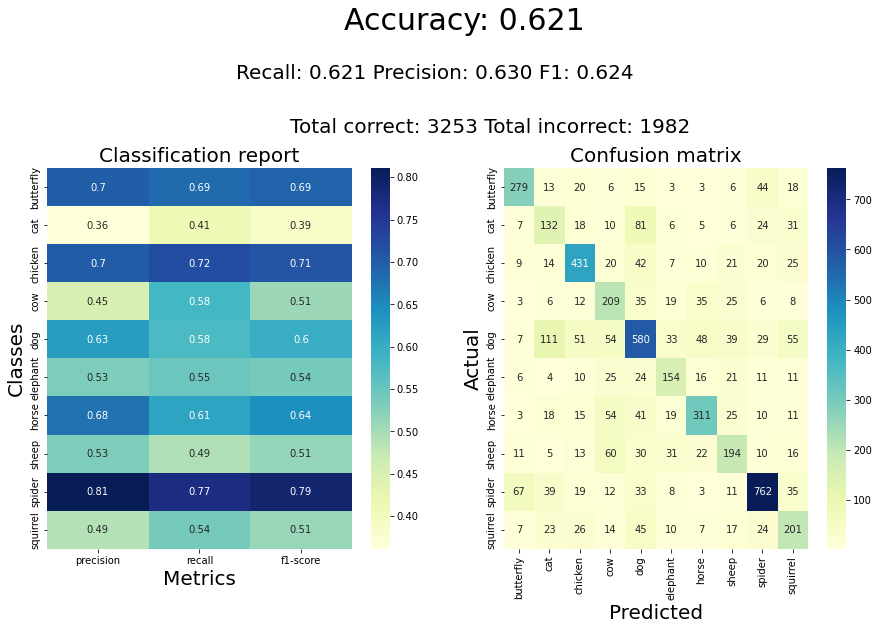

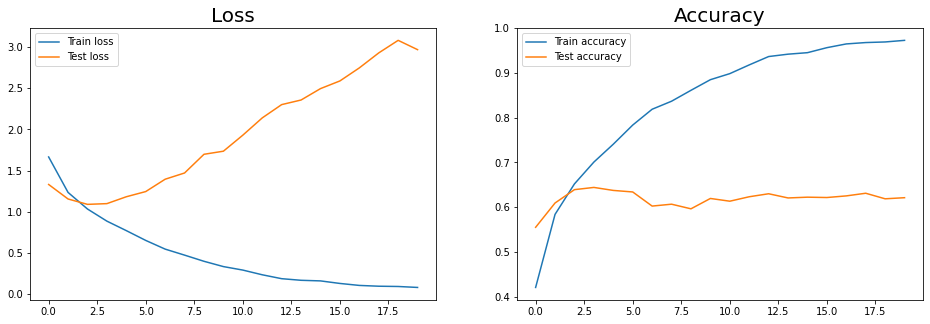

In [17]:
conv_model = tf.keras.Sequential([
    Rescaling(scale=1./255, input_shape=(image_height, image_width, 3)),
    Conv2D(filters=16, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Flatten()    
])

model = tf.keras.Sequential([
    conv_model,
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])
print(model.summary())
history = compile_fit_model(model, epochs=20)
evaluate_results(model, history)

### Large model

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 1152)              97440     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               295168    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1290      
Total params: 426,794
Trainable params: 426,794
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
655/655 [==============================] - 4s 5ms/step - loss: 1.8147 - accuracy: 0.3564 - val_loss: 1.4946 - val_accuracy: 0.4772
Epoch 2/30
655/655 [==============================] - 4s 6ms/step - loss: 1.3706 - accuracy: 0.523

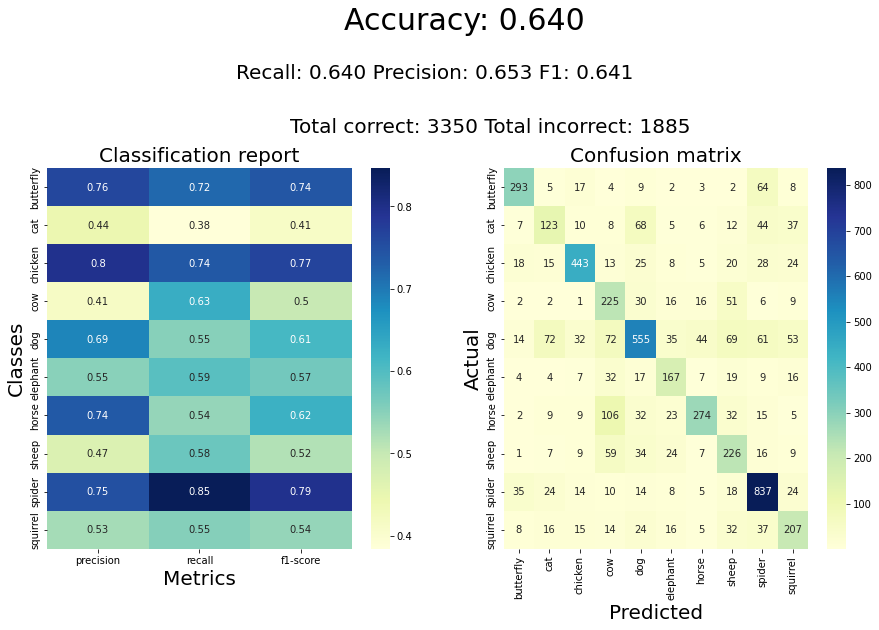

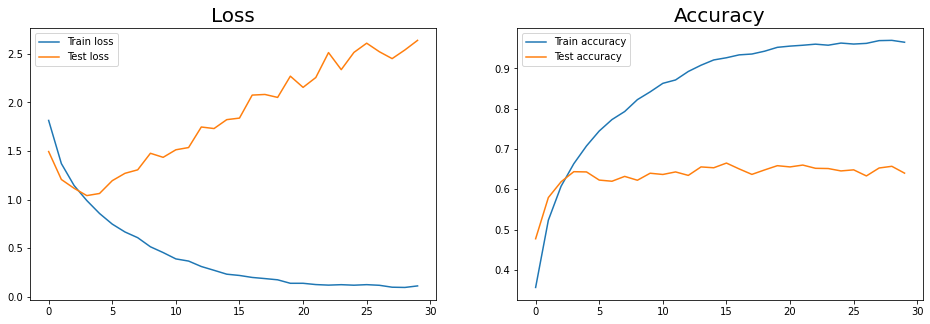

In [22]:
conv_model = tf.keras.Sequential([
    Rescaling(scale=1./255, input_shape=(image_height, image_width, 3)),
    Conv2D(filters=16, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Flatten()    
])

model = tf.keras.Sequential([
    conv_model,
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])
print(model.summary())
history = compile_fit_model(model, epochs=30)
evaluate_results(model, history)

### Huge model

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 2304)              388416    
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              2360320   
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                1290      
Total params: 3,439,050
Trainable params: 3,439,050
Non-trainable params: 0
___________________________________________

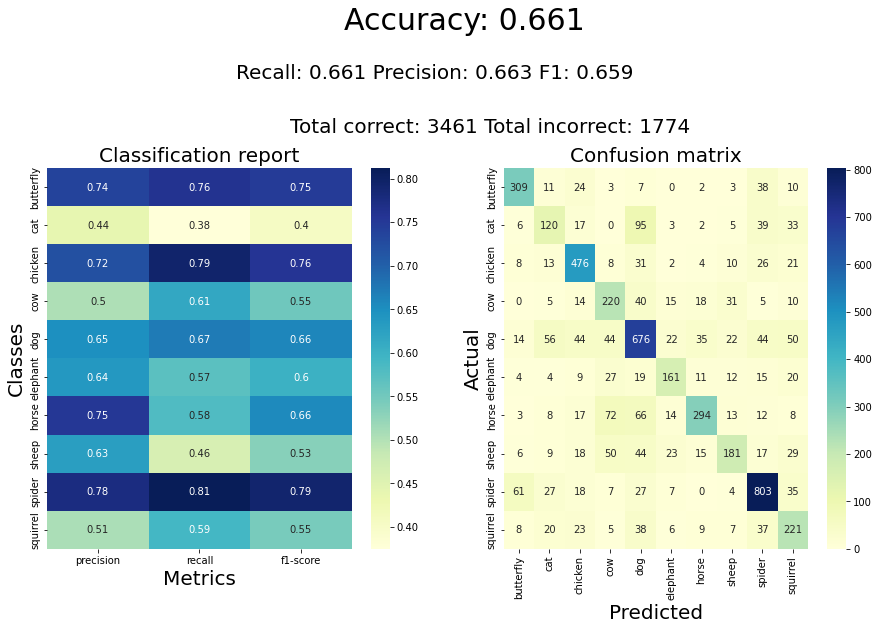

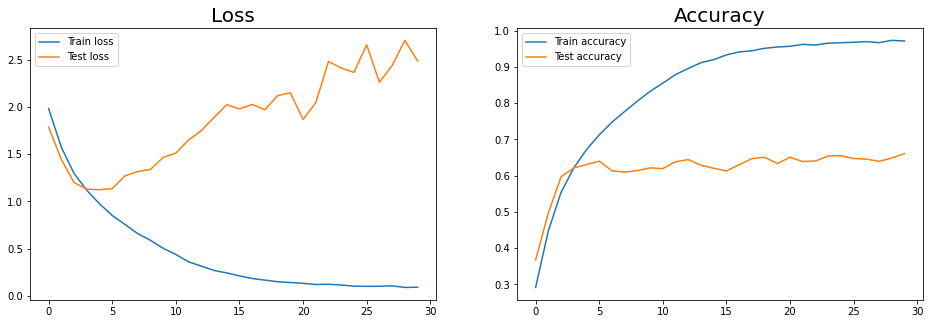

In [23]:
conv_model = tf.keras.Sequential([
    Rescaling(scale=1./255, input_shape=(image_height, image_width, 3)),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Flatten()    
])

model = tf.keras.Sequential([
    conv_model,
    Dense(1024, activation='relu'),  
    Dense(512, activation='relu'),   
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])
print(model.summary())
history = compile_fit_model(model, epochs=30)
evaluate_results(model, history)

## <span style="color:#01872A; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 30px; "> Step 4 results:</span>

### 1. All Models shows signs of overfitting:High train results and poor test results
### 2. Will use 'Huge' model to remove overfitting.

<div id="Step5">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 5. Reduce overfitting. </span>

Ways to reduce overfitting:
1. Regularization.
2. Image augmentation.
3. Dropout.
4. Decrease model complexity.
5. Early stopping.


### Add regularization to Dense layer

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_79 (Sequential)   (None, 2304)              388416    
_________________________________________________________________
dense_162 (Dense)            (None, 1024)              2360320   
_________________________________________________________________
dense_163 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_164 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_165 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_166 (Dense)            (None, 10)                1290      
Total params: 3,439,050
Trainable params: 3,439,050
Non-trainable params: 0
___________________________________________

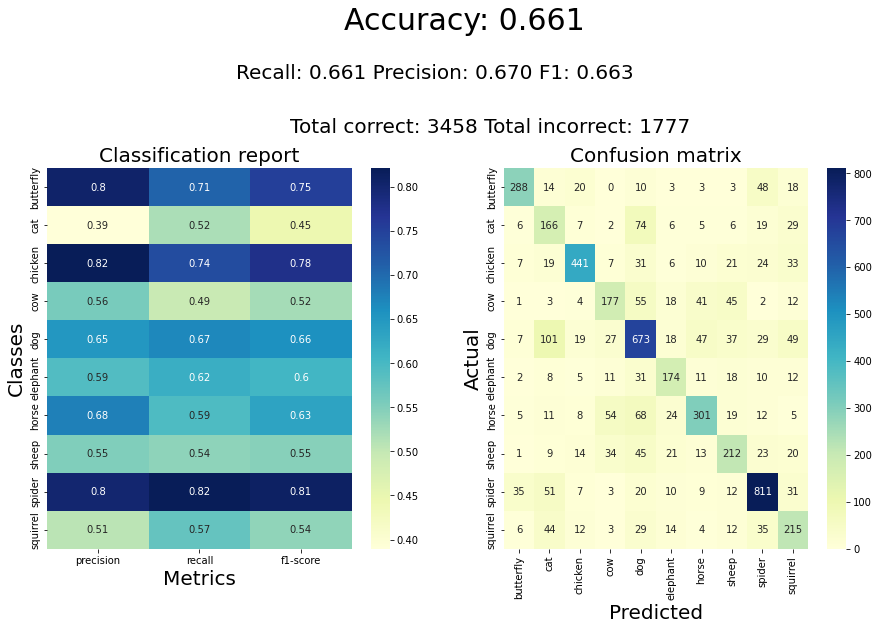

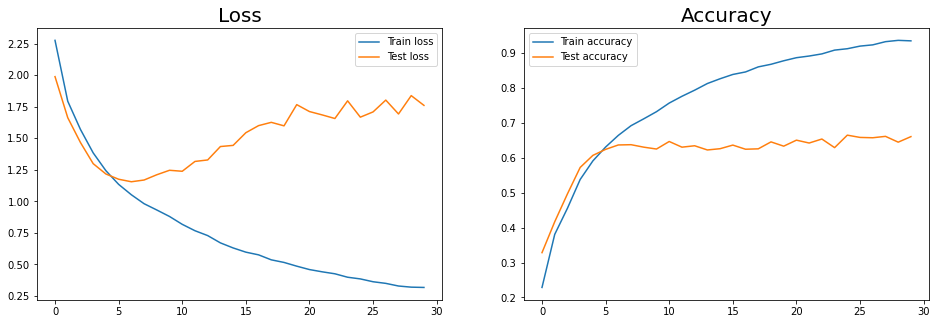

In [56]:
conv_model = tf.keras.Sequential([
    Rescaling(scale=1./255, input_shape=(image_height, image_width, 3)),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Flatten()    
])

model = tf.keras.Sequential([
    conv_model,
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),  
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),   
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(n_classes, activation='softmax')
])
print(model.summary())
history = compile_fit_model(model, epochs=30)
evaluate_results(model, history)

### Regularization decreased overfitting but predictive power of the model stayed the same

### Adding Image Augmentation and early stopping (10 epochs)

Model: "sequential_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_150 (Sequential)  (None, 80, 80, 3)         0         
_________________________________________________________________
sequential_151 (Sequential)  (None, 2304)              388416    
_________________________________________________________________
dense_282 (Dense)            (None, 1024)              2360320   
_________________________________________________________________
dense_283 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_284 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_285 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_286 (Dense)            (None, 64)             

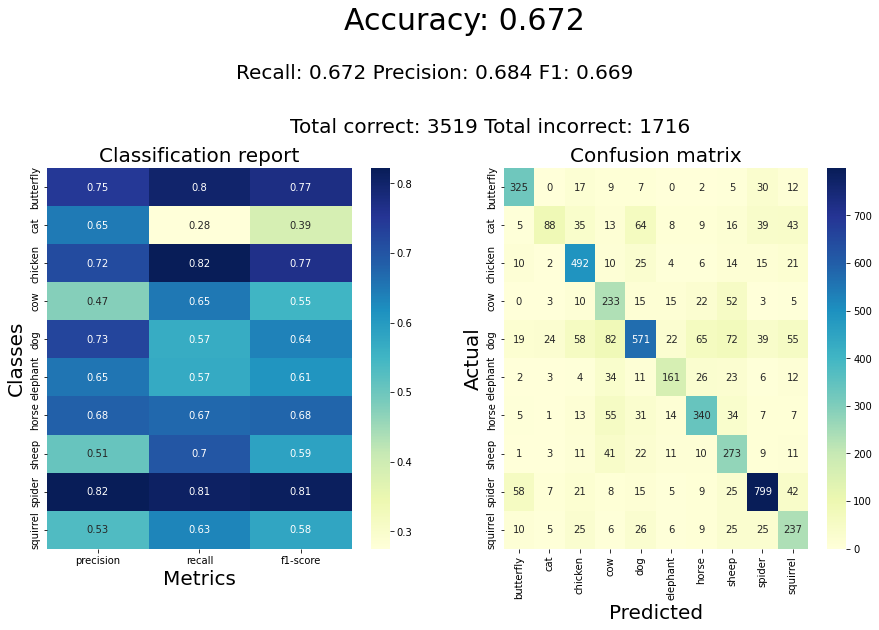

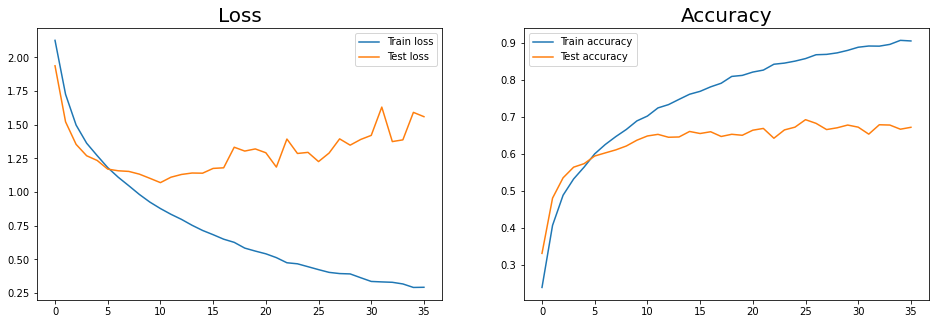

In [81]:
augmentation_model = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip('horizontal', input_shape=(image_height, image_width, 3)),
    tf.keras.layers.RandomZoom(0.1)
])

conv_model = tf.keras.Sequential([
    Rescaling(scale=1./255, input_shape=(image_height, image_width, 3)),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Flatten()    
])

model = tf.keras.Sequential([
    augmentation_model,
    conv_model,
    Dense(1024, activation='relu'),  
    Dense(512, activation='relu'),   
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])
print(model.summary())
history = compile_fit_model(model, epochs=60, callbacks=[early_stopping])
evaluate_results(model, history)

### Image augmentation both:
* Decreased overfitting
* Improved model accuracy

### Add dropout and batch normalization for faster convergence

Model: "sequential_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_153 (Sequential)  (None, 80, 80, 3)         0         
_________________________________________________________________
sequential_154 (Sequential)  (None, 2304)              390336    
_________________________________________________________________
dropout_63 (Dropout)         (None, 2304)              0         
_________________________________________________________________
dense_288 (Dense)            (None, 1024)              2360320   
_________________________________________________________________
dropout_64 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_289 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_65 (Dropout)         (None, 512)            

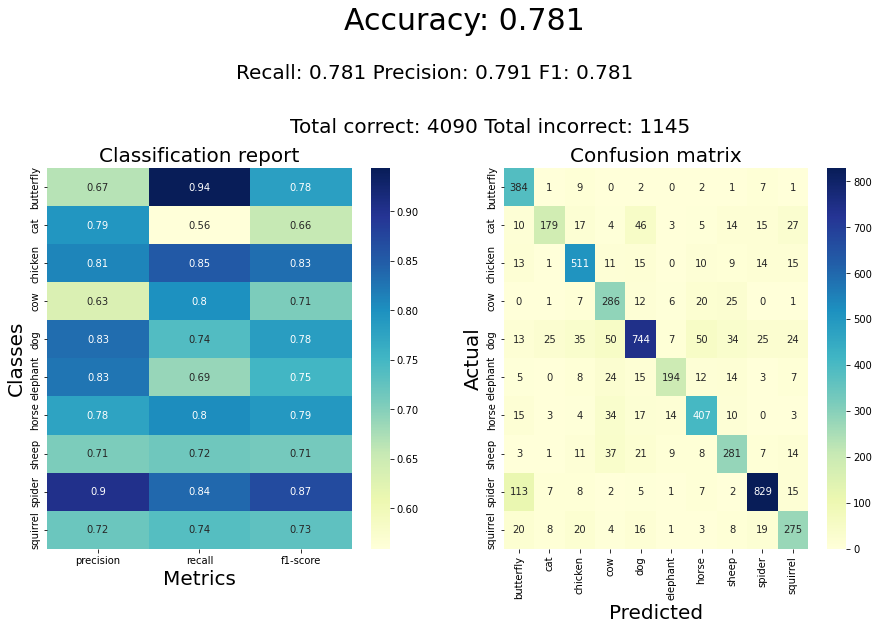

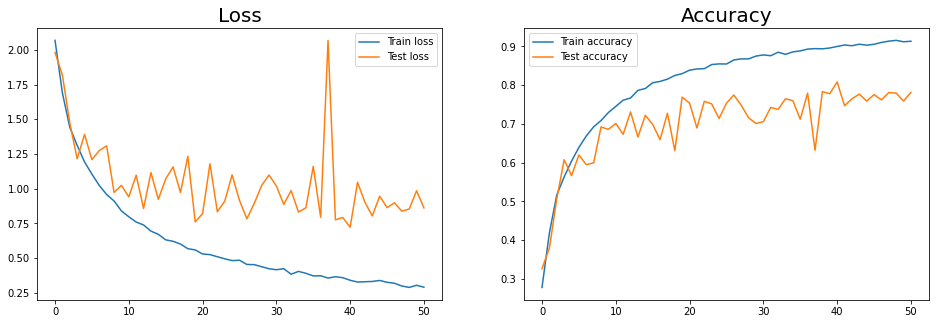

In [82]:
augmentation_model = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip('horizontal', input_shape=(image_height, image_width, 3)),
    tf.keras.layers.RandomZoom(0.1)
])

conv_model = tf.keras.Sequential([
    Rescaling(scale=1./255, input_shape=(image_height, image_width, 3)),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten()    
])

model = tf.keras.Sequential([
    augmentation_model,
    conv_model,
    Dropout(0.3),
    Dense(1024, activation='relu'),  
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])
print(model.summary())
history = compile_fit_model(model, epochs=60, callbacks=[early_stopping])
evaluate_results(model, history)

## <span style="color:#01872A; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 30px; "> Step 5 results:</span>

### 1. After applying anti-overfitting methods accuracy score, precision and recal scores improved.

<div id="Step6">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 6. Conclusion. </span>

### 1. Common and CNN-specific methods that confront overfitting can improve score of the model.
### 2. Common methods:
2.1. Dropout layer.

2.2. BatchNormalization layer.
### 3. Specific methods:
3.1. Image augmentation.
### 3. System of animal-recognition was created and shows more-or-less well results.